In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pywt
import os
import sys
from importlib import reload
from pyedflib import highlevel
from scipy.signal import butter, lfilter

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# Подгружаем пути к директориям с нашими алгоритмами:
script_path = os.path.join(os.getcwd(), "../../Scripts/")
sys.path.append(script_path)
import data_generator as dgen


In [51]:
dgen.init(filter=True)
amy, amyc, norm = dgen.read_data()

In [52]:
norm_parts = dgen.crop(norm)
amy_parts = dgen.crop(amy)
amyc_parts = dgen.crop(amyc)

Изучим общее количество фрагментов для каждого класса

In [53]:
print(len(norm_parts), "- Norm parts")
print(len(amy_parts), "- amy parts")
print(len(amyc_parts), "- amyc parts")

norm_parts = np.array(norm_parts)
amy_parts = np.array(amy_parts)
amyc_parts = np.array(amyc_parts)

510 - Norm parts
396 - amy parts
310 - amyc parts


In [54]:
def extract_statistical_features(ecg_signal):
    features = {}
    features['std'] = pd.Series(np.std(ecg_signal, axis=1))
    features['min'] = pd.Series(np.min(ecg_signal, axis=1))
    features['max'] = pd.Series(np.max(ecg_signal, axis=1))
    features['range'] = pd.Series(np.ptp(ecg_signal, axis=1))  # max - min
    return features

def extract_frequency_features(ecg_signal):
    # Преобразование Фурье
    fft = np.fft.fft(ecg_signal)
    fft_mag = np.abs(fft)
    
    # Извлекаем частотные признаки
    features = {}
    features['freq_std'] = pd.Series(np.std(fft_mag, axis=1))
    features['freq_max'] = pd.Series(np.max(fft_mag, axis=1))
    
    return features

def extract_wavelet_features(ecg_signal):
    coeffs = pywt.wavedec(ecg_signal, 'db4', level=4)
    features = {}
    
    # Извлечение статистики для каждого уровня
    for i, coeff in enumerate(coeffs):
        features[f'wavelet_std_level_{i}'] = pd.Series(np.std(coeff, axis=1))
    
    return features


А теперь поделим данные на трейн тест по людям, и после порежем сигналы на части

In [55]:
data_raw = norm + amyc + amy
#data_raw = norm + amy
lab = np.concatenate([np.zeros(len(norm) + len(amyc)), np.ones(len(amy))])
#lab = np.concatenate([np.zeros(len(norm)), np.ones(len(amy))])
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(data_raw, lab, test_size=0.2, random_state=42)

data_train = []
y_train = []
data_test = []
y_test = []

for i in range(len(X_train_raw)):
    temp = dgen.crop([X_train_raw[i]])
    data_train.extend(temp)
    y_train.extend(y_train_raw[i] * np.ones(len(temp)))

for i in range(len(X_test_raw)):
    temp = dgen.crop([X_test_raw[i]])
    data_test.extend(temp)
    y_test.extend(y_test_raw[i] * np.ones(len(temp)))

data_train = np.array(data_train)
y_train = np.array(y_train)
data_test = np.array(data_test)
y_test = np.array(y_test)


In [56]:
X_train = pd.DataFrame({**extract_statistical_features(data_train), **extract_frequency_features(data_train), **extract_wavelet_features(data_train)})
X_test = pd.DataFrame({**extract_statistical_features(data_test), **extract_frequency_features(data_test), **extract_wavelet_features(data_test)})

# Классификатор Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Оценка точности
y_pred = rf.predict(X_test)
print(f"Random Forest accuracy: {accuracy_score(y_test, y_pred)}")

# Классификатор SVM
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print(f"SVM accuracy: {accuracy_score(y_test, y_pred_svm)}")

Random Forest accuracy: 0.5182481751824818
SVM accuracy: 0.5109489051094891


In [57]:
X_train.head()

,std,min,max,range,freq_std,freq_max,wavelet_std_level_0,wavelet_std_level_1,wavelet_std_level_2,wavelet_std_level_3,wavelet_std_level_4
0,0.046272,-0.168021,0.379208,0.547229,1.147340,6.951244,0.154481,0.112674,0.020805,0.005908,0.000517
1,0.059087,-0.184676,0.401154,0.585829,1.499088,7.970947,0.154708,0.155275,0.026819,0.007622,0.000568
2,0.045365,-0.219806,0.340648,0.560454,1.117306,6.028767,0.121454,0.118408,0.040619,0.006084,0.000482
3,0.061239,-0.227669,0.355922,0.583590,1.549573,9.104526,0.173845,0.167473,0.034068,0.007382,0.000554
4,0.047295,-0.238566,0.344987,0.583553,1.191720,7.711607,0.109155,0.125648,0.047202,0.005480,0.000446


Простая важность

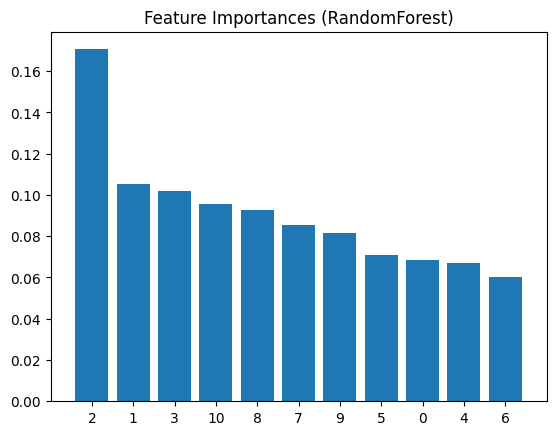

Feature 2: 0.1705661097167746
Feature 1: 0.10517882509045967
Feature 3: 0.10203211678319814
Feature 10: 0.09546900070740293
Feature 8: 0.09267610621481902
Feature 7: 0.08551175662547295
Feature 9: 0.08165811065105175
Feature 5: 0.07109727897932554
Feature 0: 0.06837497032278542
Feature 4: 0.06701576470862783
Feature 6: 0.060419960200082154


In [58]:
# Получение важности признаков
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Визуализация важности признаков
plt.figure()
plt.title("Feature Importances (RandomForest)")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

# Вывод важности признаков
for i in range(X_train.shape[1]):
    print(f"Feature {indices[i]}: {importances[indices[i]]}")

Permutation importance

In [59]:
from sklearn.inspection import permutation_importance

# Оценка перестановочной важности признаков
perm_importance = permutation_importance(rf, X_train, y_train, n_repeats=100, random_state=42)

# Получение важности и сортировка
indices = np.argsort(perm_importance.importances_mean)[::-1]

# Вывод важности признаков
for i in range(X_train.shape[1]):
    print(f"Feature {indices[i]}: {perm_importance.importances_mean[indices[i]]}")

Feature 2: 0.15626326963906578
Feature 1: 0.054670912951167716
Feature 8: 0.04118895966029723
Feature 10: 0.026751592356687892
Feature 7: 0.026220806794055196
Feature 3: 0.02409766454352441
Feature 5: 0.0197452229299363
Feature 9: 0.011040339702760082
Feature 6: 0.008704883227176219
Feature 0: 0.002016985138004246
Feature 4: 0.0007430997876857748


SHAP Values (SHapley Additive exPlanations)

(942, 11)


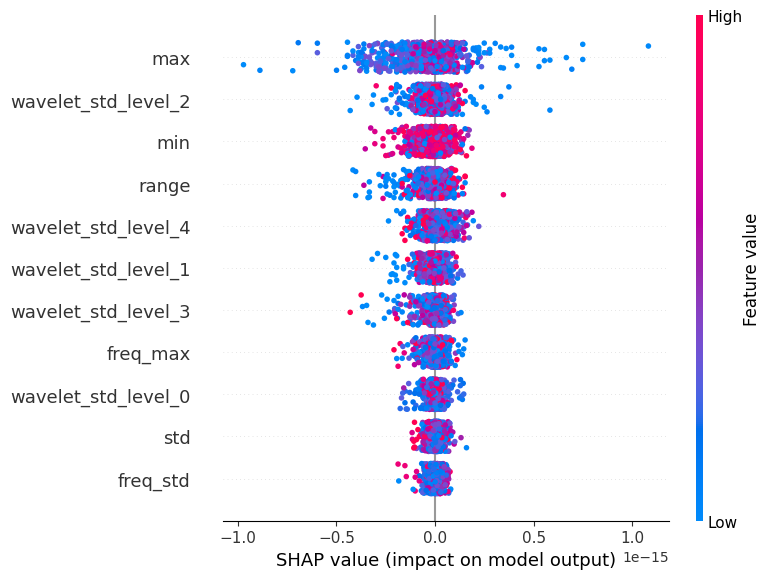

In [72]:
import shap 
# Создание объекта SHAP explainer
explainer = shap.TreeExplainer(rf)

# Получение SHAP values
shap_values = explainer.shap_values(X_train)


# Визуализация важности признаков
# shap.summary_plot(shap_values, X_train, plot_size=(12, 8))
# Для бинарной классификации можно усреднить SHAP values
mean_shap_values = np.mean(shap_values, axis=2)
print(mean_shap_values.shape)
shap.summary_plot(mean_shap_values, X_train)

Voting accuracy: 0.6242424242424243

 clasification report:
               precision    recall  f1-score   support

         0.0       0.70      0.70      0.70       105
         1.0       0.48      0.48      0.48        60

    accuracy                           0.62       165
   macro avg       0.59      0.59      0.59       165
weighted avg       0.62      0.62      0.62       165

Матрица несоответствий для тестовой выборки метода ЛДА:



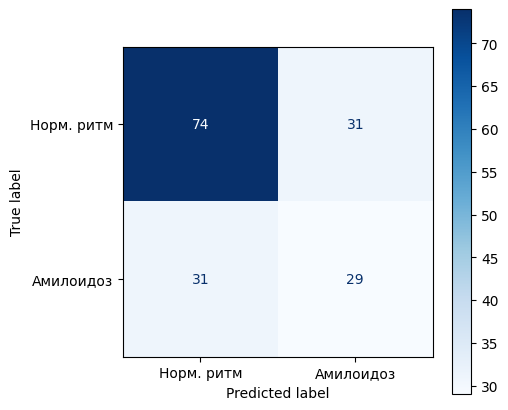

In [19]:
# Создание нескольких классификаторов
rf = RandomForestClassifier(criterion='log_loss')
svm = SVC(probability=True)
# Добавим классификаторы в ансамбль
voting_clf = VotingClassifier(estimators=[('rf', rf), ('svm', svm)], voting='soft')

# Обучение ансамбля
voting_clf.fit(X_train, y_train)

# Оценка точности
y_pred_voting = voting_clf.predict(X_test)
print(f"Voting accuracy: {accuracy_score(y_test, y_pred_voting)}")

# Замените названия классов на соответствующие вам
class_names = ['Норм. ритм', 'Амилоидоз']

print ('\n clasification report:\n', classification_report(y_test, y_pred_voting))

print('Матрица несоответствий для тестовой выборки метода ЛДА:\n')
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_voting), display_labels= class_names)
disp.plot(cmap = 'Blues', ax=ax);


Сетка ниже фигня полная


Epoch 1/10, Loss: 0.683185709019502
Epoch 2/10, Loss: 0.6709674969315529
Epoch 3/10, Loss: 0.6795821463068327
Epoch 4/10, Loss: 0.6665130977829298
Epoch 5/10, Loss: 0.6653098786870638
Epoch 6/10, Loss: 0.6618071173628172
Epoch 7/10, Loss: 0.6658593043684959
Epoch 8/10, Loss: 0.65523678312699
Epoch 9/10, Loss: 0.6563560018936793
Epoch 10/10, Loss: 0.6603580067555109
Accuracy: 52.121212121212125%
Voting accuracy: 0.5212121212121212

 clasification report:
               precision    recall  f1-score   support

         0.0       0.62      0.65      0.63       105
         1.0       0.33      0.30      0.31        60

    accuracy                           0.52       165
   macro avg       0.47      0.47      0.47       165
weighted avg       0.51      0.52      0.52       165

Матрица несоответствий для тестовой выборки метода ЛДА:



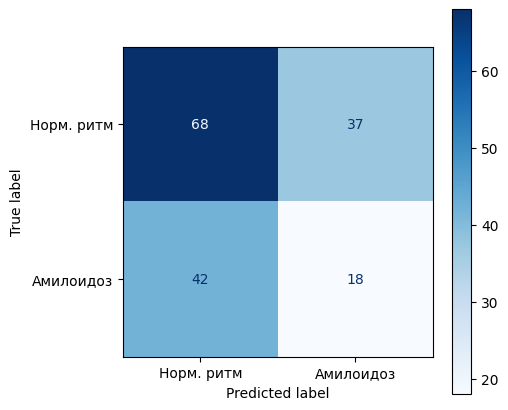

In [20]:
X_train = torch.tensor(pd.DataFrame({**extract_statistical_features(data_train), \
    **extract_frequency_features(data_train), **extract_wavelet_features(data_train)}).to_numpy(), dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(pd.DataFrame({**extract_statistical_features(data_test), \
    **extract_frequency_features(data_test), **extract_wavelet_features(data_test)}).to_numpy(), dtype=torch.float32).unsqueeze(1)

train_dataset, test_dataset = TensorDataset(X_train, torch.tensor(y_train, dtype=torch.long)), TensorDataset(X_test, torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Определяем модель CNN
class ECG_CNN(nn.Module):
    def __init__(self):
        super(ECG_CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 3, 100)  # Рассчитайте размер выходного тензора после всех сверточных слоев
        self.fc2 = nn.Linear(100, 2)  # Выходной слой для двух классов

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 3)  # Выпрямляем тензор для fully connected слоев
        x = torch.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=1)
        return x


# Создаем объект модели, определяем loss и optimizer
model = ECG_CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Функция для обучения модели
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            # Нулим градиенты
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass и оптимизация
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}')

# Функция для тестирования модели
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy: {100 * correct / total}%')

# Обучаем модель
train_model(model, train_loader, criterion, optimizer, epochs=10)

# Тестируем модель
test_model(model, test_loader)

# Оценка точности
y = model(X_test).detach().numpy()
y_pred = []
for i in range(len(y)):
    if y[i][0] > y[i][1]:
        y_pred.append(0)
    else:
        y_pred.append(1)
print(f"Voting accuracy: {accuracy_score(y_test, y_pred)}")

# Замените названия классов на соответствующие вам
class_names = ['Норм. ритм', 'Амилоидоз']

print ('\n clasification report:\n', classification_report(y_test, y_pred))

print('Матрица несоответствий для тестовой выборки метода ЛДА:\n')
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels= class_names)
disp.plot(cmap = 'Blues', ax=ax);



In [21]:
signal_len = dgen.signal_len
normalize = dgen.normalize

def calcGroupTable(model, groupnames : list, records : list, label : int, df : pd.DataFrame):
    for i in range(len(groupnames)):
        record = records[i]
        parts = dgen.crop([record])
        y_pred = model.predict(pd.DataFrame({**extract_statistical_features(parts), **extract_frequency_features(parts), **extract_wavelet_features(parts)}))
        y_weighted = np.asarray(y_pred).sum() / len(y_pred)

        y_weighted = round(y_weighted)

        df.loc[-1] = [groupnames[i], y_weighted, label]
        df.index = df.index + 1
        df = df.sort_index()
    return df

In [22]:
# There are two classes. 0 - norm, 1 - amy

pred_tab = pd.DataFrame(columns=["name", "weighted_predict", "label"])

norm_names = os.listdir(dgen.norm_path)
amy_names = os.listdir(dgen.amy_path)
amyc_names = os.listdir(dgen.amyc_path)

norm_names = [name[:6] + "_norm" + name[6:] for name in norm_names]

pred_tab = calcGroupTable(voting_clf, norm_names, norm, 0, pred_tab)
pred_tab = calcGroupTable(voting_clf, amyc_names, amyc, 0, pred_tab)
pred_tab = calcGroupTable(voting_clf, amy_names, amy, 1, pred_tab)


pred_tab.head(5)

pred_tab.to_csv("voted_result.csv", index=False)